In [1]:
import os
os.chdir("..")

In [53]:
from src.data.data_process import DataReg
import polars as pl
import requests
import geopandas as gpd
from pysal.lib import weights
from shapely import wkt
import pandas as pd
import arviz as az
import matplotlib.dates as mdates
import numpy as np
import causalpy as cp
import matplotlib.pyplot as plt
dr = DataReg()

In [7]:
df_qcew = dr.base_data()
# df_dp03 = dr.pull_dp03()
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)

# df = df_qcew.join(df_dp03, on=["zipcode","year"], how="inner")
df = pr_zips.join(
    df_qcew.to_pandas().set_index("zipcode"), on="zipcode", how="inner", validate="1:m"
        ).reset_index(drop=True)
df

,zipcode,geometry,year,qtr,sector,mw_industry,total_employment,min_wage,k_index
0,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2005,3,51,7795.351234,15.333333,2678.0,0.343538
1,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2006,3,49,2000.000000,1.000000,2678.0,1.339000
2,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2008,4,72,2836.219618,16.048309,2678.0,0.944215
3,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2003,3,54,3068.709050,3.279279,2678.0,0.872680
4,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2001,1,99,5072.313813,8.250000,-1.0,-0.000197
...,...,...,...,...,...,...,...,...,...
231133,00830,"MULTIPOLYGON (((-64.79979 18.32668, -64.79975 ...",2005,3,72,2833.050000,13.333333,2678.0,0.945271
231134,00830,"MULTIPOLYGON (((-64.79979 18.32668, -64.79975 ...",2004,3,72,2052.477273,14.666667,2678.0,1.304765
231135,00830,"MULTIPOLYGON (((-64.79979 18.32668, -64.79975 ...",2002,1,72,2328.486486,12.333333,2678.0,1.150103
231136,00830,"MULTIPOLYGON (((-64.79979 18.32668, -64.79975 ...",2006,1,72,2118.000000,13.666667,2678.0,1.264400


In [8]:
sector_df = df[df["sector"] == "61"].reset_index(drop=True)
y = sector_df["total_employment"].values.reshape(-1,1)
w = weights.distance.DistanceBand.from_dataframe(
    sector_df, 80467
)
reg = sector_df
reg["w_emplyment"] = weights.lag_spatial(w,y) 
reg

,zipcode,geometry,year,qtr,sector,mw_industry,total_employment,min_wage,k_index,w_emplyment
0,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2012,4,61,4699.913729,73.666667,3770.0,0.802142,1.425978e+06
1,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2023,1,61,7536.754020,130.901961,4420.0,0.586459,1.425978e+06
2,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2019,4,61,5554.930608,88.129630,3770.0,0.678676,1.425978e+06
3,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2017,3,61,4218.484912,108.000000,3770.0,0.893686,1.425978e+06
4,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2018,4,61,5118.804849,98.823529,3770.0,0.736500,1.425978e+06
...,...,...,...,...,...,...,...,...,...,...
10078,00952,"POLYGON ((-66.21234 18.43874, -66.21235 18.438...",2012,4,61,2362.500000,4.000000,3770.0,1.595767,1.435428e+06
10079,00952,"POLYGON ((-66.21234 18.43874, -66.21235 18.438...",2014,1,61,2362.500000,4.000000,3770.0,1.595767,1.435428e+06
10080,00952,"POLYGON ((-66.21234 18.43874, -66.21235 18.438...",2013,4,61,2362.500000,4.000000,3770.0,1.595767,1.435428e+06
10081,00952,"POLYGON ((-66.21234 18.43874, -66.21235 18.438...",2013,2,61,2362.500000,2.666667,3770.0,1.595767,1.435428e+06


In [ ]:
treatment_time = 2023

result = cp.SyntheticControl(
    reg,
    treatment_time,
    formula="total_employment ~ 0 + k_index + w_emplyment + inc_less_10k",
    model=cp.skl_models.WeightedProportion(),
)
fig, ax = result.plot(plot_predictors=True)

In [ ]:
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)

In [44]:
empty_df = [pl.Series("date", [], dtype=pl.String)]
for zips in list(pr_zips["zipcode"].values):
    empty_df.append(pl.Series(zips, [], dtype=pl.Int32))
df_master = pl.DataFrame(empty_df)
df_master

date,00791,00769,00667,00953,00612,00777,00690,00754,00631,00611,00720,00707,00723,00647,00901,00692,00956,00950,00745,00741,00913,00917,00921,00983,00961,00982,00638,00637,00783,00653,00907,00603,00912,00976,00736,00909,…,00766,00678,00918,00927,00728,00656,00662,00682,00714,00674,00616,00795,00727,00725,00729,00924,00773,00767,00794,00669,00602,00622,00920,00979,00646,00771,00784,00925,00985,00969,00952,00850,00830,00802,00851,00820,00840
str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32


In [32]:
df = dr.conn.sql("SELECT first_month_employment, second_month_employment, third_month_employment, ui_addr_5_zip, qtr, year FROM qcewtable").pl()

In [33]:
tmp = df.drop_nulls()
tmp = tmp.filter(pl.col("ui_addr_5_zip").is_in(list(pr_zips["zipcode"].values)))
tmp  = tmp.group_by(["year", "qtr","ui_addr_5_zip"]).agg(
    first_month_employment = pl.col("first_month_employment").sum(),
    second_month_employment = pl.col("second_month_employment").sum(),
    third_month_employment = pl.col("third_month_employment").sum()
)

tmp = tmp.with_columns(
    ui_addr_5_zip="zip_" + pl.col("ui_addr_5_zip")
)

In [34]:
def foo(df:pl.DataFrame, year, qtr):
    df = df.filter((pl.col("year") == year) & (pl.col("qtr") == qtr))
    if df.is_empty():
        return df
    names = df.select(pl.col("ui_addr_5_zip")).transpose()
    names = names.to_dicts().pop()
    df = df.drop("year", "qtr", "ui_addr_5_zip").transpose(include_header=True)
    df = df.rename(names)
    df = df.with_columns(
        date=pl.when((qtr == 1) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-01-01"))
               .when((qtr == 1) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-02-01"))
               .when((qtr == 1) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-03-01"))
               .when((qtr == 2) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-04-01"))
               .when((qtr == 2) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-05-01"))
               .when((qtr == 2) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-06-01"))
               .when((qtr == 3) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-07-01"))
               .when((qtr == 3) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-08-01"))
               .when((qtr == 3) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-09-01"))
               .when((qtr == 4) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-10-01"))
               .when((qtr == 4) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-11-01"))
               .when((qtr == 4) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-12-01"))
               .otherwise(pl.lit("ERROR"))
    )
    return df.drop("column")

foo(tmp, 2021, 1)

zip_00966,zip_00631,zip_00676,zip_00677,zip_00704,zip_00650,zip_00727,zip_00784,zip_00641,zip_00610,zip_00969,zip_00923,zip_00911,zip_00725,zip_00767,zip_00921,zip_00951,zip_00906,zip_00705,zip_00960,zip_00674,zip_00924,zip_00840,zip_00622,zip_00909,zip_00925,zip_00719,zip_00961,zip_00959,zip_00693,zip_00678,zip_00617,zip_00682,zip_00647,zip_00741,zip_00757,zip_00751,…,zip_00670,zip_00718,zip_00918,zip_00624,zip_00917,zip_00971,zip_00982,zip_00979,zip_00611,zip_00956,zip_00953,zip_00731,zip_00773,zip_00623,zip_00707,zip_00920,zip_00965,zip_00690,zip_00780,zip_00662,zip_00738,zip_00601,zip_00692,zip_00602,zip_00735,zip_00716,zip_00976,zip_00636,zip_00680,zip_00616,zip_00983,zip_00952,zip_00694,zip_00683,zip_00957,zip_00698,date
i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str
8428,403,3574,1625,148,1078,1629,1464,1501,2802,12834,355,986,10842,1776,6727,8355,1100,3826,19492,12095,962,10,720,1777,1614,2878,3414,2863,2074,1552,4238,1381,305,447,2770,1524,…,700,1211,12004,1687,5336,317,650,6214,87,2837,1713,964,1060,3493,659,3201,1345,603,2391,4263,2914,1020,2119,3263,932,2893,1523,2,3344,157,1047,2320,2907,6051,721,3973,"""2021-01-01"""
8733,404,3594,1636,150,1042,1628,1460,1505,2782,12626,350,1020,10839,1822,6821,8313,1097,3855,19553,12120,952,12,738,1793,1629,2961,3429,3089,2085,1562,4249,1397,307,441,2689,1556,…,704,1231,12125,1688,5215,321,671,6277,85,2891,1729,966,1079,3568,633,3183,1342,603,2393,4218,2939,1022,2137,3262,949,2928,1544,2,3355,150,1063,2320,2901,6156,756,3999,"""2021-02-01"""
9041,405,3743,1661,149,1057,1678,1495,1530,2863,12363,354,1043,10865,1833,6817,8317,1093,3873,19836,12151,989,9,760,1813,1697,3069,3547,2955,2104,1607,4344,1538,316,448,2760,1598,…,715,1254,12195,1716,5307,326,675,6238,87,2983,1784,974,1123,3808,684,3322,1343,638,2422,4188,2997,1040,2202,3368,957,3002,1563,2,3431,157,1100,2417,2924,6174,769,4046,"""2021-03-01"""


In [45]:
for year in [2023, 2024]:
    for qtr in range(1,5):
        something = foo(tmp,year, qtr)
        if something.is_empty():
            continue
        df_master = pl.concat([df_master, something], how="diagonal")
df_master

date,00791,00769,00667,00953,00612,00777,00690,00754,00631,00611,00720,00707,00723,00647,00901,00692,00956,00950,00745,00741,00913,00917,00921,00983,00961,00982,00638,00637,00783,00653,00907,00603,00912,00976,00736,00909,…,zip_00616,zip_00694,zip_00682,zip_00979,zip_00690,zip_00647,zip_00771,zip_00983,zip_00907,zip_00623,zip_00906,zip_00650,zip_00704,zip_00775,zip_00745,zip_00603,zip_00925,zip_00636,zip_00740,zip_00956,zip_00736,zip_00962,zip_00606,zip_00731,zip_00739,zip_00719,zip_00659,zip_00652,zip_00949,zip_00678,zip_00612,zip_00766,zip_00777,zip_00617,zip_00784,zip_00703,zip_00915
str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
"""2023-01-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,136,3245,1425,10906,698,298,6439,1496,13664,5415,101,711,136,332,3869,2222,4117,4,345,3620,1763,564,410,1089,6053,3426,4105,314,2233,1894,5599,1530,6389,4302,1429,1776,194
"""2023-02-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,138,3244,1502,10891,708,308,6525,1510,13726,5446,98,730,135,340,3941,2224,4112,4,346,3623,1763,566,403,1096,6106,3427,4071,303,2213,1871,5557,1545,6431,4318,1432,1757,197
"""2023-03-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,136,3255,1540,10943,699,309,6792,1522,13993,6024,99,743,133,353,3971,2290,4177,4,345,3610,1783,561,423,1102,6174,3506,4142,311,2191,1962,5622,1560,6491,4350,1454,1888,198
"""2023-04-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,159,3252,1636,10585,704,301,7091,1536,14660,5659,97,855,140,354,4050,2225,4078,4,365,3597,1787,570,408,1079,6087,3395,4115,302,2239,1968,5581,1611,6570,4281,1427,1758,193
"""2023-05-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,155,3234,1500,10528,704,302,7120,1536,14673,5749,96,839,142,354,4016,2222,4130,4,362,3552,1812,573,403,1089,6105,3416,4126,293,2240,2043,5646,1617,6441,4280,1424,1757,195
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-02-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,164,3263,1417,9837,547,307,6683,1517,13687,6756,96,803,150,363,4158,2980,3674,4,368,3889,1806,592,400,1125,6225,3533,4259,286,2377,2058,5819,1593,6282,4366,1326,1806,193
"""2024-03-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,163,3297,1440,9941,544,306,6922,1509,13863,7783,96,810,155,376,4151,3052,3738,4,406,4001,1840,587,413,1133,6292,3600,4328,288,2391,2110,5878,1596,6426,4390,1331,1926,201
"""2024-04-01""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,166,3227,1382,10062,538,300,7094,1518,14338,7071,83,852,151,362,4173,2982,3784,4,404,3819,1865,603,406,1215,6465,3650,4290,278,2399,2086,5624,1636,6360,4309,1239,1789,214


In [46]:
data = df_master
columns_with_nulls = [col for col in data.columns if data[col].is_null().any()]

data = data.drop(columns_with_nulls)
data = data.to_pandas()
data["date"] = pd.to_datetime(data["date"])
treatment_time = pd.to_datetime("2024-01-01")
data.index = pd.to_datetime(data['date'])
data = data.drop('date', axis=1)
data

,zip_00627,zip_00729,zip_00976,zip_00780,zip_00637,zip_00692,zip_00917,zip_00934,zip_00968,zip_00901,...,zip_00652,zip_00949,zip_00678,zip_00612,zip_00766,zip_00777,zip_00617,zip_00784,zip_00703,zip_00915
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,3575,3735,1429,2577,2399,2145,8327,2170,21683,8701,...,314,2233,1894,5599,1530,6389,4302,1429,1776,194
2023-02-01,3530,3760,1428,2550,2371,2171,8358,2211,21908,8665,...,303,2213,1871,5557,1545,6431,4318,1432,1757,197
2023-03-01,3790,3787,1439,2602,2434,2228,8488,2218,21964,8667,...,311,2191,1962,5622,1560,6491,4350,1454,1888,198
2023-04-01,3668,3649,1463,2626,2474,2220,8460,2227,19704,7910,...,302,2239,1968,5581,1611,6570,4281,1427,1758,193
2023-05-01,3634,3665,1456,2655,2427,2219,8387,2205,19419,7773,...,293,2240,2043,5646,1617,6441,4280,1424,1757,195
2023-06-01,3839,3631,1476,2704,2378,2277,8550,2238,19619,7649,...,285,2241,2078,5995,1636,6511,4290,1412,1872,204
2023-07-01,3489,3679,1446,2671,2304,2214,8566,2257,16349,7803,...,265,2212,2107,5742,1644,6525,4330,1425,1708,190
2023-08-01,3566,3898,1462,2698,2372,2234,8518,2281,16360,7752,...,283,2252,2040,5747,1653,6413,4316,1394,1759,188
2023-09-01,3872,3948,1487,2761,2403,2254,8597,2283,16347,7706,...,286,2289,2058,5850,1652,6508,4336,1385,1887,195


In [50]:
formula = "zip_00791 ~ 0"
for col in data.columns:
    if col == "zip_00791":
        continue
    formula += f" + {col}"
formula

'zip_00791 ~ 0 + zip_00627 + zip_00729 + zip_00976 + zip_00780 + zip_00637 + zip_00692 + zip_00917 + zip_00934 + zip_00968 + zip_00901 + zip_00610 + zip_00601 + zip_00698 + zip_00631 + zip_00687 + zip_00950 + zip_00611 + zip_00688 + zip_00714 + zip_00602 + zip_00717 + zip_00802 + zip_00982 + zip_00913 + zip_00735 + zip_00927 + zip_00680 + zip_00971 + zip_00778 + zip_00772 + zip_00754 + zip_00622 + zip_00773 + zip_00783 + zip_00909 + zip_00683 + zip_00926 + zip_00641 + zip_00957 + zip_00966 + zip_00923 + zip_00707 + zip_00924 + zip_00920 + zip_00685 + zip_00660 + zip_00670 + zip_00959 + zip_00638 + zip_00965 + zip_00918 + zip_00718 + zip_00725 + zip_00667 + zip_00653 + zip_00786 + zip_00676 + zip_00960 + zip_00757 + zip_00911 + zip_00912 + zip_00765 + zip_00728 + zip_00669 + zip_00738 + zip_00723 + zip_00961 + zip_00985 + zip_00624 + zip_00840 + zip_00705 + zip_00952 + zip_00794 + zip_00851 + zip_00921 + zip_00664 + zip_00951 + zip_00730 + zip_00662 + zip_00674 + zip_00727 + zip_00969 +

In [51]:
# Import and process data
# formula = ""
result = cp.SyntheticControl(
    data,
    treatment_time,
    formula=formula,
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": 787}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/home/ouslan/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263106) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/ouslan/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263106) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/ouslan/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263106) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/home/ouslan/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263106) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


/home/ouslan/Documents/Github/pr-salaries/.venv/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (135), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta\nzip_00627'}>,
        <Axes: title={'center': 'beta\nzip_00627'}>],
       [<Axes: title={'center': 'beta\nzip_00729'}>,
        <Axes: title={'center': 'beta\nzip_00729'}>],
       [<Axes: title={'center': 'beta\nzip_00976'}>,
        <Axes: title={'center': 'beta\nzip_00976'}>],
       [<Axes: title={'center': 'beta\nzip_00780'}>,
        <Axes: title={'center': 'beta\nzip_00780'}>],
       [<Axes: title={'center': 'beta\nzip_00637'}>,
        <Axes: title={'center': 'beta\nzip_00637'}>],
       [<Axes: title={'center': 'beta\nzip_00692'}>,
        <Axes: title={'center': 'beta\nzip_00692'}>],
       [<Axes: title={'center': 'beta\nzip_00917'}>,
        <Axes: title={'center': 'beta\nzip_00917'}>],
       [<Axes: title={'center': 'beta\nzip_00934'}>,
        <Axes: title={'center': 'beta\nzip_00934'}>],
       [<Axes: title={'center': 'beta\nzip_00968'}>,
        <Axes: title={'center': 'beta\nzip_00968'}>],
       [<Axes: title={'center': 'beta

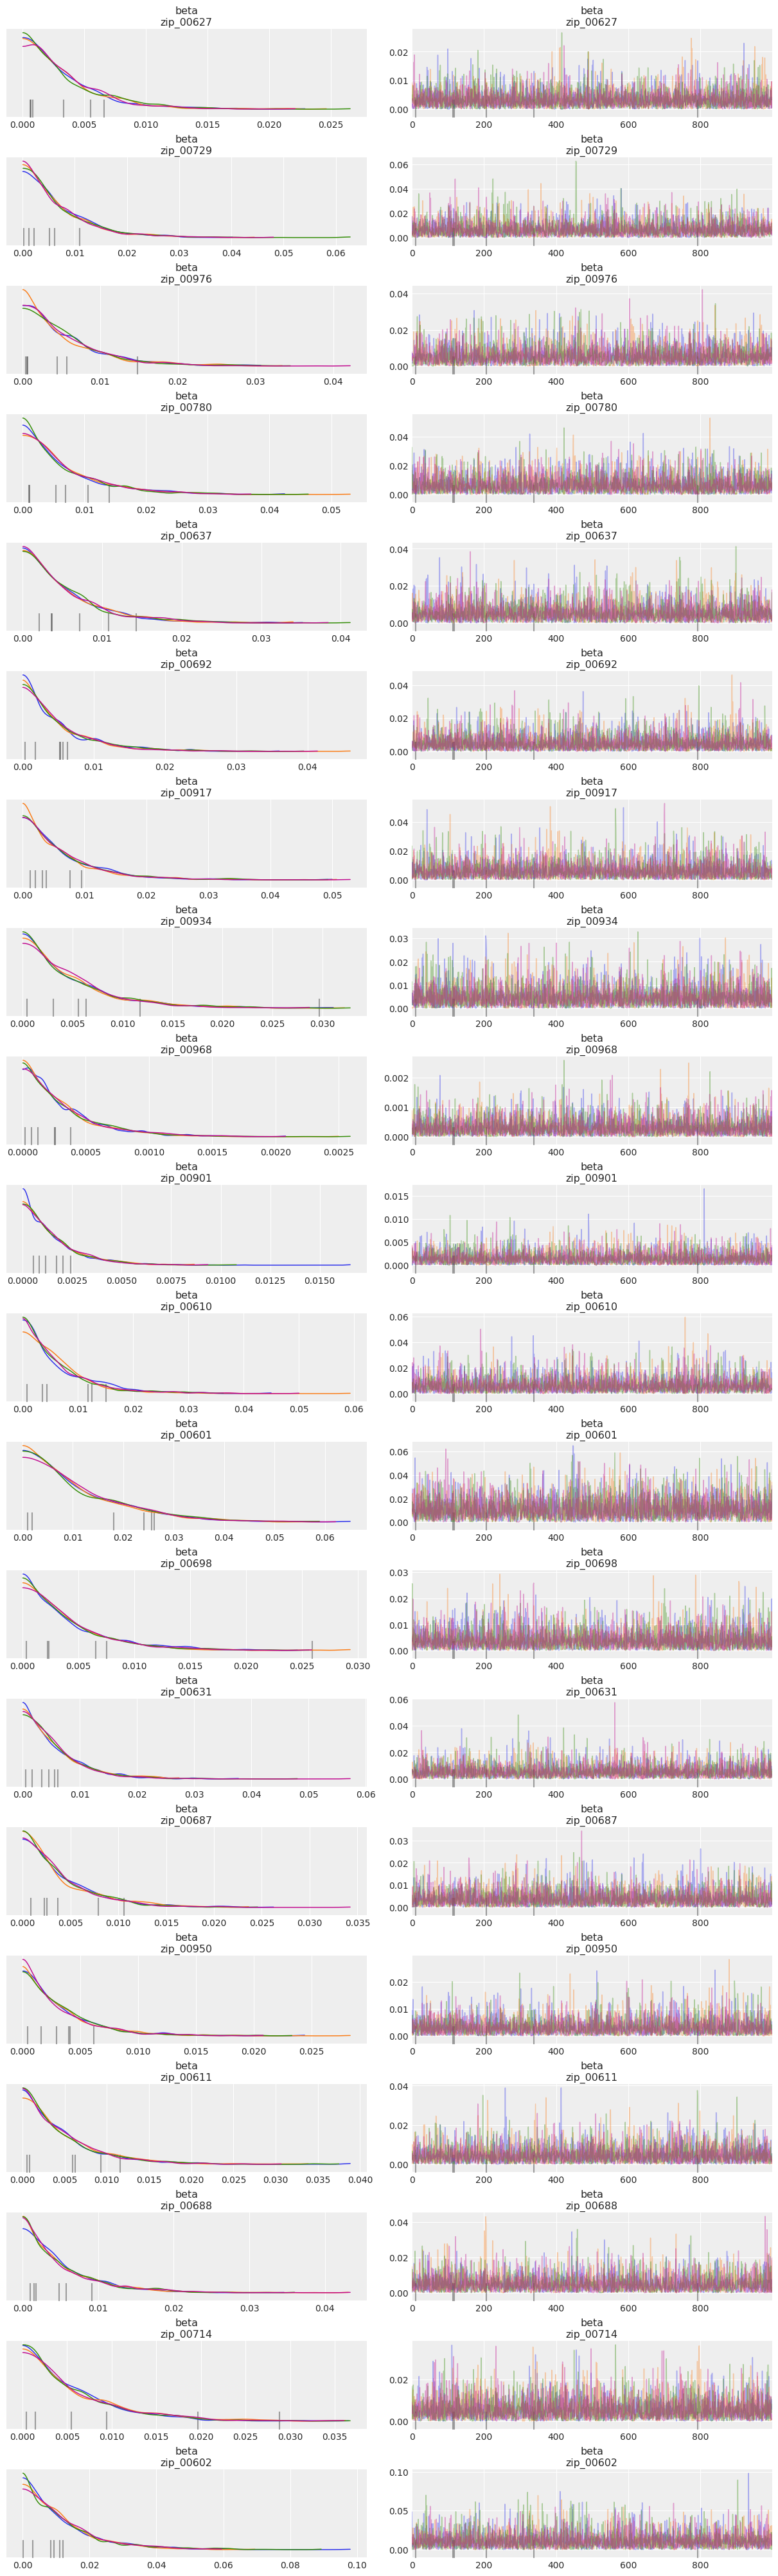

In [54]:
az.summary(result.idata, round_to=2)
az.plot_trace(result.idata, var_names=["~mu"], compact=False)

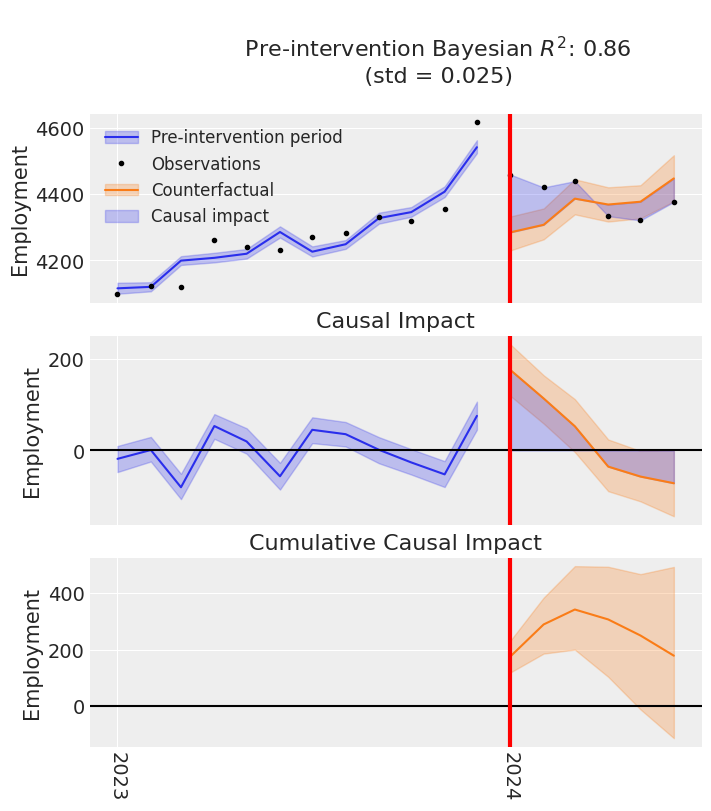

In [55]:
fig, ax = result.plot(plot_predictors=False)

# formatting
ax[2].tick_params(axis="x", labelrotation=-90)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[2].xaxis.set_major_locator(mdates.YearLocator())
for i in [0, 1, 2]:
    ax[i].set(ylabel="Employment")